In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances,accuracy_score

from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import mode

from einops import rearrange
from itertools import combinations

prithvi_config = './configs/encoder/prithvi.yaml'
dofa_config = './configs/encoder/dofa.yaml'

embed_dir = './embeddings/pairedmodalitycrops/'

seed = 726

modalities = ['l8','l9','hls','s2']

---

0. Load Embeddings For DOFA/Prithvi Models

---

In [37]:
dofa_embeds = {}
dofa_cls_tokens = {}

prithvi_embeds = {}
prithvi_cls_tokens = {}

for modality in modalities:
    prithvi_embeds_path = os.path.join(embed_dir,'prithvi',f'{modality}_embeds.npy')
    prithvi_cls_path = os.path.join(embed_dir,'prithvi',f'{modality}_cls_tokens.npy')
    prithvi_embeds[modality] = np.load(prithvi_embeds_path)
    prithvi_cls_tokens[modality] = np.load(prithvi_cls_path)

    dofa_embeds_path = os.path.join(embed_dir,'dofa',f'{modality}_embeds.npy')
    dofa_cls_path = os.path.join(embed_dir,'dofa',f'{modality}_cls_tokens.npy')
    dofa_embeds[modality] = np.load(dofa_embeds_path)
    dofa_cls_tokens[modality] = np.load(dofa_cls_path)


targets = np.load(os.path.join(embed_dir,'labels.npy'))

---

1. Pairwise TSNE Plots

---

In [38]:
colors = ListedColormap(['red','blue','green','purple'],N=4)
classes = ['l8','l9','hls','s2']

class_color_map = {
    'l8':'red',
    'l9':'blue',
    'hls':'green',
    's2':'purple'
}

---

1a. Prithvi TSNE Plots

---

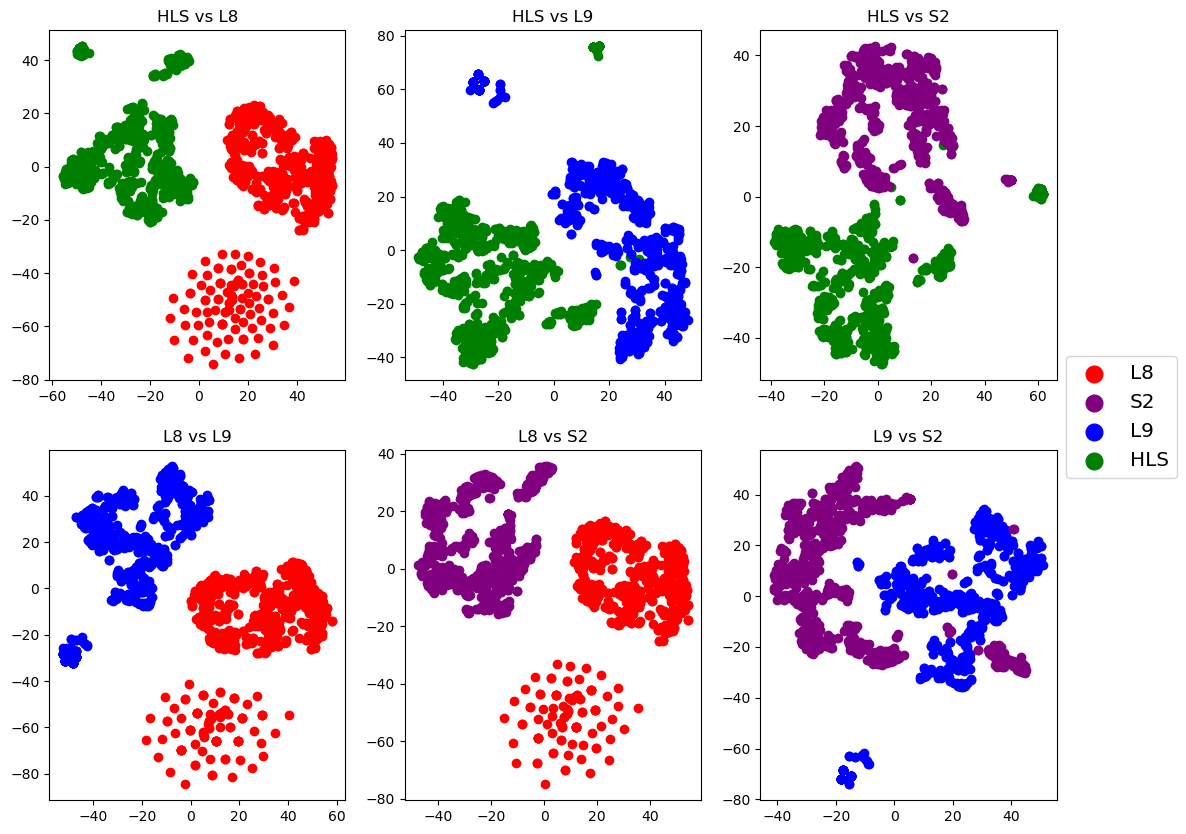

In [39]:
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(13,10))

pairs  = [[('hls','l8'), ('hls','l9'),('hls','s2')],
          [('l8','l9'),('l8','s2'),('l9','s2')]]

for i in range(len(pairs)):
    for j in range(len(pairs[0])):
        m1, m2 = pairs[i][j]
        
        tokens = np.concatenate([prithvi_cls_tokens[m1],prithvi_cls_tokens[m2]],axis=0)

        tsne = TSNE(n_components=2)

        tokens_vis = tsne.fit_transform(tokens)

        axs[i][j].scatter(tokens_vis[:len(prithvi_cls_tokens[m1]),0],tokens_vis[:len(prithvi_cls_tokens[m1]),1],label=m1.upper(),color=class_color_map[m1])
        axs[i][j].scatter(tokens_vis[len(prithvi_cls_tokens[m1]):,0],tokens_vis[len(prithvi_cls_tokens[m1]):,1],label=m2.upper(),color=class_color_map[m2])

        axs[i][j].set_title(f'{m1.upper()} vs {m2.upper()}')

line_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels  = [sum(lol, []) for lol in zip(*line_labels)]
unique_labels = set(labels)
legends_dict = dict(zip(labels,lines))
unique_lines = [legends_dict[x] for x in unique_labels]


fig.legend(unique_lines,unique_labels,loc='center right',markerscale=2,fontsize='x-large')
# plt.savefig('dofa_tsne_plot.jpg')
plt.show()

---

1b. DOFA TSNE Plots

---

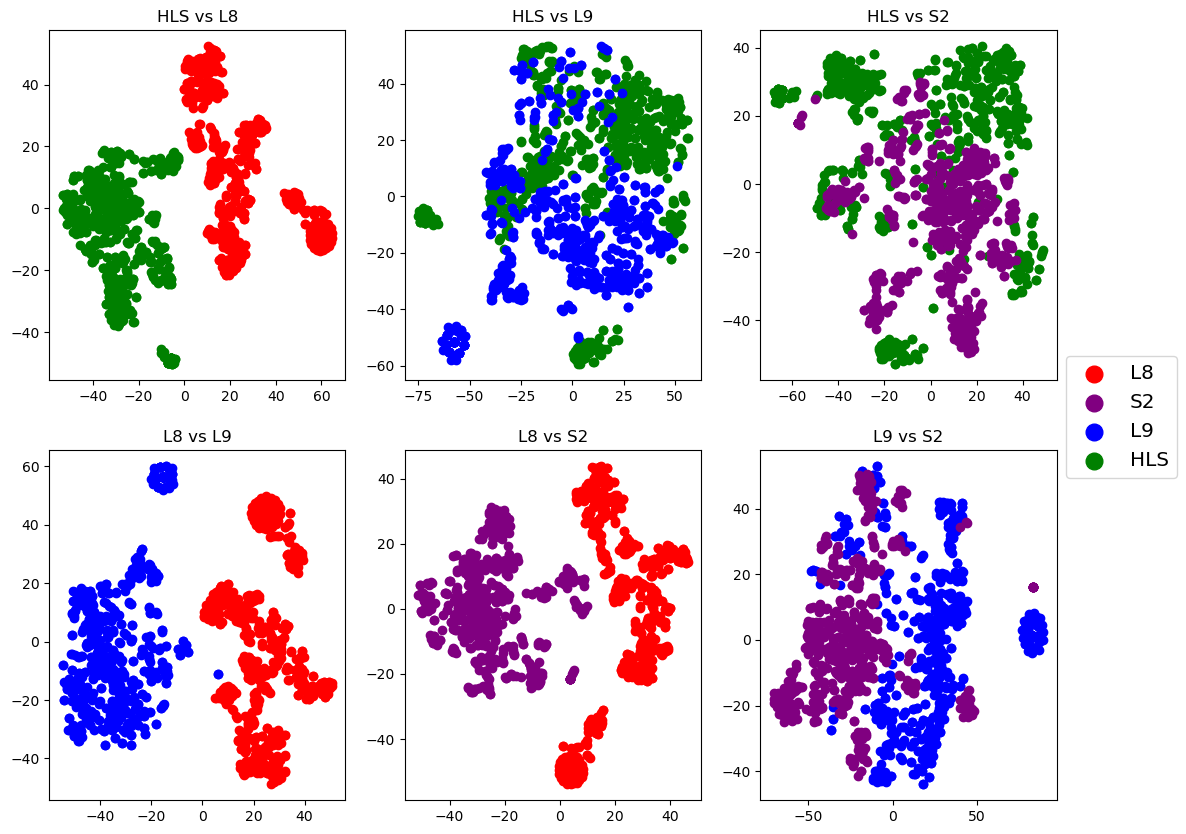

In [40]:
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(13,10))

pairs  = [[('hls','l8'), ('hls','l9'),('hls','s2')],
          [('l8','l9'),('l8','s2'),('l9','s2')]]

for i in range(len(pairs)):
    for j in range(len(pairs[0])):
        m1, m2 = pairs[i][j]
        
        tokens = np.concatenate([dofa_cls_tokens[m1],dofa_cls_tokens[m2]],axis=0)

        tsne = TSNE(n_components=2)

        tokens_vis = tsne.fit_transform(tokens)

        axs[i][j].scatter(tokens_vis[:len(dofa_cls_tokens[m1]),0],tokens_vis[:len(dofa_cls_tokens[m1]),1],label=m1.upper(),color=class_color_map[m1])
        axs[i][j].scatter(tokens_vis[len(dofa_cls_tokens[m1]):,0],tokens_vis[len(dofa_cls_tokens[m1]):,1],label=m2.upper(),color=class_color_map[m2])

        axs[i][j].set_title(f'{m1.upper()} vs {m2.upper()}')

line_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels  = [sum(lol, []) for lol in zip(*line_labels)]
unique_labels = set(labels)
legends_dict = dict(zip(labels,lines))
unique_lines = [legends_dict[x] for x in unique_labels]


fig.legend(unique_lines,unique_labels,loc='center right',markerscale=2,fontsize='x-large')
# plt.savefig('dofa_tsne_plot.jpg')
plt.show()

---

2. Neighborhood Analysis Computation

---

2a. Prithvi Neighborhood Analysis

In [41]:
from sklearn.metrics.pairwise import pairwise_distances

l8_sim = pairwise_distances(prithvi_cls_tokens['l8'],prithvi_cls_tokens['l8'],metric='cosine')
l9_sim = pairwise_distances(prithvi_cls_tokens['l9'],prithvi_cls_tokens['l9'],metric='cosine')
hls_sim  = pairwise_distances(prithvi_cls_tokens['hls'],prithvi_cls_tokens['hls'],metric='cosine')
s2_sim = pairwise_distances(prithvi_cls_tokens['s2'],prithvi_cls_tokens['s2'],metric='cosine')

l8_sim = pairwise_distances(prithvi_cls_tokens['l8'],prithvi_cls_tokens['l8'],metric='cosine')
l9_sim = pairwise_distances(prithvi_cls_tokens['l9'],prithvi_cls_tokens['l9'],metric='cosine')
hls_sim  = pairwise_distances(prithvi_cls_tokens['hls'],prithvi_cls_tokens['hls'],metric='cosine')
s2_sim = pairwise_distances(prithvi_cls_tokens['s2'],prithvi_cls_tokens['s2'],metric='cosine')


l8_knn = np.argsort(l8_sim,axis=1)
l9_knn = np.argsort(l9_sim,axis=1)
hls_knn = np.argsort(hls_sim,axis=1)
s2_knn = np.argsort(s2_sim,axis=1)

n_neighbors = 20
results = {
    'l8':{
        'neighbors':l8_knn,
        'distances':l8_sim
    },
    'l9':{
        'neighbors':l9_knn,
        'distances':l9_sim
    },
    'hls':{
        'neighbors':hls_knn,
        'distances':hls_sim
    },
    's2':{
        'neighbors':s2_knn,
        'distances':s2_sim
    }
}

modalities = ['l8','l9','hls', 's2']


In [42]:
optical_modalities = ['l8','l9','hls','s2']
n_neighbors_candidates = [5,10,20]

for n_neighbors in n_neighbors_candidates:
    print(f'{n_neighbors}-Nearest Neighbors Results')
    for (m1,m2) in list(combinations(optical_modalities,r=2)):

        pct_matching = []

        m1_neighbors = results[m1]['neighbors'][:,1:n_neighbors+1]
        m2_neighbors = results[m2]['neighbors'][:,1:n_neighbors+1]

        intersections = []
        for i in range(len(m1_neighbors)):
            overlap = np.intersect1d(m1_neighbors[i],m2_neighbors[i])

            intersections.append(overlap)

        num_matches = [len(intersection) for intersection in intersections]
        pct_matching = [len(intersection) / n_neighbors for intersection in intersections]


        print(f'Avg # Mtching Neighbors {np.round(np.mean(num_matches))}| Average Pct Matching Neighbors {m1} & {m2}: {np.mean(pct_matching)}')

5-Nearest Neighbors Results
Avg # Mtching Neighbors 2.0| Average Pct Matching Neighbors l8 & l9: 0.37633333333333335
Avg # Mtching Neighbors 1.0| Average Pct Matching Neighbors l8 & hls: 0.142
Avg # Mtching Neighbors 0.0| Average Pct Matching Neighbors l8 & s2: 0.09766666666666667
Avg # Mtching Neighbors 1.0| Average Pct Matching Neighbors l9 & hls: 0.21833333333333332
Avg # Mtching Neighbors 1.0| Average Pct Matching Neighbors l9 & s2: 0.13366666666666666
Avg # Mtching Neighbors 1.0| Average Pct Matching Neighbors hls & s2: 0.192
10-Nearest Neighbors Results
Avg # Mtching Neighbors 4.0| Average Pct Matching Neighbors l8 & l9: 0.4175
Avg # Mtching Neighbors 2.0| Average Pct Matching Neighbors l8 & hls: 0.16233333333333333
Avg # Mtching Neighbors 1.0| Average Pct Matching Neighbors l8 & s2: 0.11566666666666668
Avg # Mtching Neighbors 2.0| Average Pct Matching Neighbors l9 & hls: 0.23333333333333334
Avg # Mtching Neighbors 2.0| Average Pct Matching Neighbors l9 & s2: 0.152
Avg # Mtching 

2b. DOFA Neighborhood Analysis

In [43]:
from sklearn.metrics.pairwise import pairwise_distances

l8_sim = pairwise_distances(dofa_cls_tokens['l8'],dofa_cls_tokens['l8'],metric='cosine')
l9_sim = pairwise_distances(dofa_cls_tokens['l9'],dofa_cls_tokens['l9'],metric='cosine')
hls_sim  = pairwise_distances(dofa_cls_tokens['hls'],dofa_cls_tokens['hls'],metric='cosine')
s2_sim = pairwise_distances(dofa_cls_tokens['s2'],dofa_cls_tokens['s2'],metric='cosine')

l8_sim = pairwise_distances(dofa_cls_tokens['l8'],dofa_cls_tokens['l8'],metric='cosine')
l9_sim = pairwise_distances(dofa_cls_tokens['l9'],dofa_cls_tokens['l9'],metric='cosine')
hls_sim  = pairwise_distances(dofa_cls_tokens['hls'],dofa_cls_tokens['hls'],metric='cosine')
s2_sim = pairwise_distances(dofa_cls_tokens['s2'],dofa_cls_tokens['s2'],metric='cosine')


l8_knn = np.argsort(l8_sim,axis=1)
l9_knn = np.argsort(l9_sim,axis=1)
hls_knn = np.argsort(hls_sim,axis=1)
s2_knn = np.argsort(s2_sim,axis=1)

n_neighbors = 20
results = {
    'l8':{
        'neighbors':l8_knn,
        'distances':l8_sim
    },
    'l9':{
        'neighbors':l9_knn,
        'distances':l9_sim
    },
    'hls':{
        'neighbors':hls_knn,
        'distances':hls_sim
    },
    's2':{
        'neighbors':s2_knn,
        'distances':s2_sim
    }
}

modalities = ['l8','l9','hls', 's2']

In [44]:
optical_modalities = ['l8','l9','hls','s2']
n_neighbors_candidates = [5,10,20]

for n_neighbors in n_neighbors_candidates:
    print(f'{n_neighbors}-Nearest Neighbors Results')
    for (m1,m2) in list(combinations(optical_modalities,r=2)):

        pct_matching = []

        m1_neighbors = results[m1]['neighbors'][:,1:n_neighbors+1]
        m2_neighbors = results[m2]['neighbors'][:,1:n_neighbors+1]

        intersections = []
        for i in range(len(m1_neighbors)):
            overlap = np.intersect1d(m1_neighbors[i],m2_neighbors[i])

            intersections.append(overlap)

        num_matches = [len(intersection) for intersection in intersections]
        pct_matching = [len(intersection) / n_neighbors for intersection in intersections]


        print(f'Avg # Mtching Neighbors {np.round(np.mean(num_matches))}| Average Pct Matching Neighbors {m1} & {m2}: {np.mean(pct_matching)}')

5-Nearest Neighbors Results
Avg # Mtching Neighbors 2.0| Average Pct Matching Neighbors l8 & l9: 0.3440000000000001
Avg # Mtching Neighbors 1.0| Average Pct Matching Neighbors l8 & hls: 0.1406666666666667
Avg # Mtching Neighbors 1.0| Average Pct Matching Neighbors l8 & s2: 0.11666666666666667
Avg # Mtching Neighbors 1.0| Average Pct Matching Neighbors l9 & hls: 0.22466666666666668
Avg # Mtching Neighbors 1.0| Average Pct Matching Neighbors l9 & s2: 0.164
Avg # Mtching Neighbors 1.0| Average Pct Matching Neighbors hls & s2: 0.21966666666666668
10-Nearest Neighbors Results
Avg # Mtching Neighbors 4.0| Average Pct Matching Neighbors l8 & l9: 0.377
Avg # Mtching Neighbors 1.0| Average Pct Matching Neighbors l8 & hls: 0.14833333333333334
Avg # Mtching Neighbors 1.0| Average Pct Matching Neighbors l8 & s2: 0.12116666666666667
Avg # Mtching Neighbors 2.0| Average Pct Matching Neighbors l9 & hls: 0.23416666666666666
Avg # Mtching Neighbors 2.0| Average Pct Matching Neighbors l9 & s2: 0.181
Avg

---

3. Patch Neighborhood Plots

---

In [45]:
labels_flat = rearrange(targets,'n p q h w -> (n h w) (p q)')
mode_values, mode_counts = mode(labels_flat,axis=1)

unique, counts = np.unique(mode_values,return_counts=True)

modes = pd.Series(dict(zip(unique,counts)))

neighborhood_results = {
    'l8':{},
    'l9':{},
    'hls':{},
    's2':{}
}

n_neighbors = 11

for modality in modalities:

    dofa_embed = rearrange(dofa_embeds[modality],'n c h w -> (n h w) c')

    prithvi_embed = rearrange(prithvi_embeds[modality],'n c h w -> (n h w) c')

    prithvi_model = NearestNeighbors(n_neighbors=n_neighbors,metric='cosine')
    dofa_model = NearestNeighbors(n_neighbors=n_neighbors,metric='cosine')

    dofa_model.fit(dofa_embed)
    prithvi_model.fit(prithvi_embed)

    _ , dofa_indices = dofa_model.kneighbors(dofa_embed)

    _ , prithvi_indices = prithvi_model.kneighbors(prithvi_embed) 

    random_indices = np.random.uniform(0,len(dofa_embed),size=prithvi_indices.shape).astype(np.int64)

    dofa_neighborhood = mode_values[dofa_indices]

    dofa_similar_neighbors = (dofa_neighborhood[:,0][:,None] == dofa_neighborhood[:,1:])
    dofa_pct_similar = np.sum(dofa_similar_neighbors,axis=1) / n_neighbors

    neighborhood_results[modality]['dofa'] = np.mean(dofa_pct_similar)

    prithvi_neighborhood = mode_values[prithvi_indices]

    prithvi_similar_neighbors = (prithvi_neighborhood[:,0][:,None] == prithvi_neighborhood[:,1:])
    prithvi_pct_similar = np.sum(prithvi_similar_neighbors,axis=1) / n_neighbors

    neighborhood_results[modality]['prithvi'] = np.mean(prithvi_pct_similar)

    random_neighborhood = mode_values[random_indices]
    random_similar_neighbors = (random_neighborhood[:,0][:,None] == random_neighborhood[:,1:])
    random_pct_similar = np.sum(random_similar_neighbors,axis=1) / n_neighbors

    neighborhood_results[modality]['random'] = np.mean(random_pct_similar)


modality_neighborhood_results = pd.DataFrame.from_dict(neighborhood_results)

print(modality_neighborhood_results)

               l8        l9       hls        s2
dofa     0.490123  0.684639  0.720520  0.705451
prithvi  0.473072  0.561068  0.594636  0.555932
random   0.241893  0.242479  0.242427  0.241456


---

4. Patch Modality Prediction

---

In [46]:
hls_process = rearrange(prithvi_embeds['hls'],'n c h w -> (n h w) c')
s2_process = rearrange(prithvi_embeds['s2'],'n c h w -> (n h w) c')
l8_process = rearrange(prithvi_embeds['l8'],'n c h w -> (n h w) c')
l9_process = rearrange(prithvi_embeds['l9'],'n c h w -> (n h w) c')



y = np.array([0]*len(hls_process) + [1]*len(s2_process) + [2]*len(l8_process) + [3]*len(l9_process))

X = np.concatenate([hls_process,s2_process,l8_process,l9_process],axis=0)
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=seed,shuffle=True)


In [ ]:
rf = RandomForestClassifier(n_estimators=500)

rf.fit(X_train,y_train)

pred = rf.predict(X_test)

print(f'Prithvi Patch Prediction Results - Random Forest: {accuracy_score(y_test,pred)}')


knn = KNeighborsClassifier(n_neighbors=5)

hls_process = rearrange(prithvi_embeds['hls'],'n c h w -> (n h w) c')
s2_process = rearrange(prithvi_embeds['s2'],'n c h w -> (n h w) c')
l8_process = rearrange(prithvi_embeds['l8'],'n c h w -> (n h w) c')
l9_process = rearrange(prithvi_embeds['l9'],'n c h w -> (n h w) c')


knn.fit(X_train,y_train)

pred = knn.predict(X_test)

print(f'Prithvi Patch Prediction Results - 5-Nearest Neighbors {accuracy_score(y_test,pred)}')

Prithvi Patch Prediction Results - Random Forest: 0.9923384353741497
Prithvi Patch Prediction Results - 5-Nearest Neighbors 0.9970663265306122


In [48]:
hls_process = rearrange(dofa_embeds['hls'],'n c h w -> (n h w) c')
s2_process = rearrange(dofa_embeds['s2'],'n c h w -> (n h w) c')
l8_process = rearrange(dofa_embeds['l8'],'n c h w -> (n h w) c')
l9_process = rearrange(dofa_embeds['l9'],'n c h w -> (n h w) c')

y = np.array([0]*len(hls_process) + [1]*len(s2_process) + [2]*len(l8_process) + [3]*len(l9_process))

X = np.concatenate([hls_process,s2_process,l8_process,l9_process],axis=0)

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=seed,shuffle=True)

In [ ]:
rf = RandomForestClassifier(n_estimators=500)

rf.fit(X_train,y_train)

pred = rf.predict(X_test)

print(f'DOFA Patch Prediction Results - Random Forest {accuracy_score(y_test,pred)}')

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train,y_train)

pred = knn.predict(X_test)

print(accuracy_score(y_test,pred))


print(f'DOFA Patch Prediction Results - 5-Nearest Neighbors {accuracy_score(y_test,pred)}')

DOFA Patch Prediction Results - Random Forest 0.9692517006802721
0.9897874149659864
DOFA Patch Prediction Results - 5-Nearest Neighbors 0.9897874149659864
